https://www.pymc-labs.com/blog-posts/markov-process/

In [182]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [183]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls.csv")

In [184]:
df = pd.read_csv("../Data/raw/president_polls.csv")
#df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df.loc[df['answer'] == 'Kennedy', 'party'] = 'IND'
df = df[df['party'] != 'OTH']

In [185]:
df['date'] = pd.to_datetime(df['end_date'])
df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_19630/2456293558.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [186]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [187]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way["IND"] = 0
df_2way[['DEM', 'GOP', 'IND']] = df_2way[['DEM', 'GOP', 'IND']].div(df_2way[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way['type'] = '2way'

In [188]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden', 'Robert F. Kennedy'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_3way = df_polls.merge(df_count)
df_3way = df_3way.rename(columns={'REP':'GOP'})
df_3way[['DEM', 'GOP', 'IND']] = df_3way[['DEM', 'GOP', 'IND']].div(df_3way[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)

df_3way['sample_size'] = round(df_3way['sample_size'] * (df_3way['DEM'] + df_3way['GOP'] + df_3way['IND'])/100)
df_3way['type'] = '3way'

In [189]:
df4 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Robert F. Kennedy', 'Joe Biden'})

df_count = df4.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df4.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_bk = df_polls.merge(df_count)
df_2way_bk["GOP"] = 0
df_2way_bk[['DEM', 'GOP', 'IND']] = df_2way_bk[['DEM', 'GOP', 'IND']].div(df_2way_bk[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)
df_2way_bk['sample_size'] = round(df_2way_bk['sample_size'] * (df_2way_bk['DEM'] + df_2way_bk['IND'])/100)
df_2way_bk['type'] = '2way_bk'

In [190]:
df5 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Robert F. Kennedy', 'Donald Trump'})

df_count = df5.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df5.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_tk = df_polls.merge(df_count)
df_2way_tk = df_2way_tk.rename(columns={'REP':'GOP'})
df_2way_tk["DEM"] = 0
df_2way_tk[['DEM', 'GOP', 'IND']] = df_2way_tk[['DEM', 'GOP', 'IND']].div(df_2way_tk[['DEM', 'GOP', 'IND']].sum(axis=1), axis=0)
df_2way_tk['sample_size'] = round(df_2way_tk['sample_size'] * (df_2way_tk['GOP'] + df_2way_tk['IND'])/100)
df_2way_tk['type'] = '2way_tk'

In [191]:
df = pd.concat([df_2way, df_3way, df_2way_bk, df_2way_tk])
df.dropna()
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Apply the function to create 'type_id' column
df['type_bt'] = (df['type'] == '2way').astype(int)
df['type_btk'] = (df['type'] == '3way').astype(int)
df['type_bk'] = (df['type'] == '2way_bk').astype(int)
df['type_tk'] = (df['type'] == '2way_tk').astype(int)

Two way Biden vs Trump, it's a dead tie

In [192]:
df_2way.query("state == 'US'")[['DEM', 'GOP']].describe()

,DEM,GOP
count,534.000000,534.000000
mean,0.491927,0.508073
std,0.013393,0.013393
min,0.441860,0.439024
25%,0.483903,0.500000
50%,0.494118,0.505882
75%,0.500000,0.516097
max,0.560976,0.558140


Two way Biden vs Kennedy, Kennedy leads by 10% (only one observation)

In [193]:
df_2way_bk.query("state == 'US'")[['DEM', 'IND']].describe()

,DEM,IND
count,1.000000,1.000000
mean,0.459184,0.540816
std,NaN,NaN
min,0.459184,0.540816
25%,0.459184,0.540816
50%,0.459184,0.540816
75%,0.459184,0.540816
max,0.459184,0.540816


Two way Trump vs Kennedy, they are tied (only one observation)

In [194]:
df_2way_tk.query("state == 'US'")[['GOP', 'IND']].describe()

,GOP,IND
count,1.00000,1.00000
mean,0.49702,0.50298
std,NaN,NaN
min,0.49702,0.50298
25%,0.49702,0.50298
50%,0.49702,0.50298
75%,0.49702,0.50298
max,0.49702,0.50298


Three way race, Trump leads Biden by 3%. We can conclude that Kennedy takes more votes from Biden and is a serious factor in the race.

In [195]:
df_3way.query("state == 'US'")[['DEM', 'GOP', 'IND']].describe()

,DEM,GOP,IND
count,232.000000,232.000000,232.000000
mean,0.426136,0.457470,0.116395
std,0.029966,0.022817,0.041748
min,0.347368,0.375000,0.022472
25%,0.406898,0.444541,0.091954
50%,0.425410,0.460034,0.115108
75%,0.446965,0.474099,0.141702
max,0.494382,0.501155,0.243902


In [196]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2021, and they have been ramping up since.

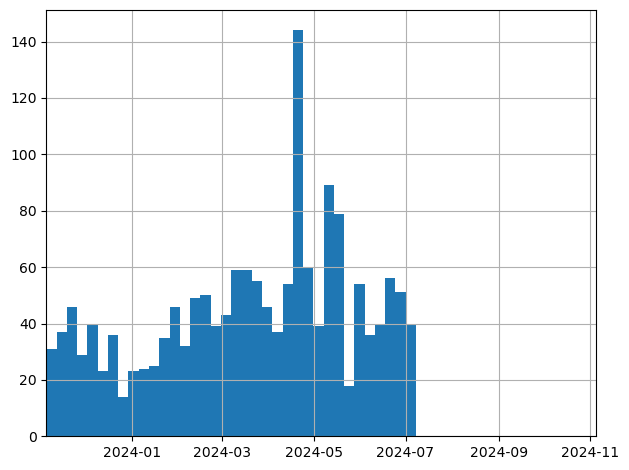

In [197]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))

plt.tight_layout()
plt.show()

In [198]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Live Phone/Text-to-Web,Probability Panel,IVR/Online Panel,Online Panel/Text-to-Web/Text,IVR/Online Panel/Text-to-Web,IVR/Text-to-Web,IVR/Online Panel/Email,Online Panel/Text-to-Web
pollster,,,,,,,,,,,
All,1638,867,128,113,85,52,46,43,40,39,31
Morning Consult,364,364,0,0,0,0,0,0,0,0,0
Emerson,115,0,0,0,0,16,0,40,0,39,1
John Zogby Strategies,104,104,0,0,0,0,0,0,0,0,0
YouGov,81,81,0,0,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,67,0,0,0,0,28,0,0,34,0,0
Big Data Poll,66,0,0,0,0,0,46,0,0,0,0
Ipsos,45,0,0,0,45,0,0,0,0,0,0
Redfield & Wilton Strategies,43,43,0,0,0,0,0,0,0,0,0


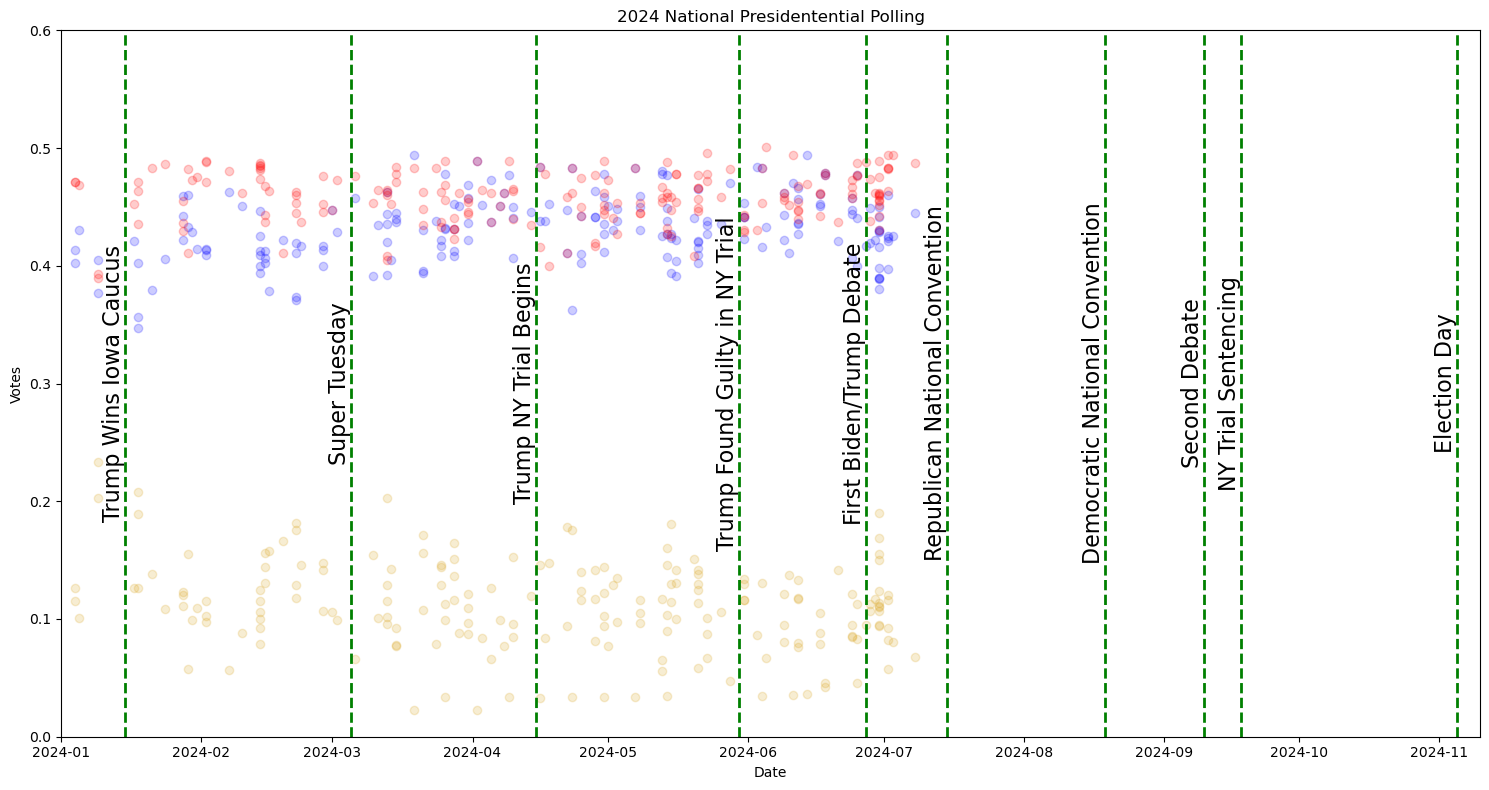

In [199]:
dem_votes = df_3way.query("state == 'US'")["DEM"].values
gop_votes = df_3way.query("state == 'US'")["GOP"].values
ind_votes = df_3way.query("state == 'US'")["IND"].values

dates = df_3way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")
ax.plot(dates, ind_votes, "o", alpha=0.2, color='goldenrod', label="Kennedy")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
#ax.plot(dt.datetime(2024, 11, 5), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
#ax.plot(dt.datetime(2024, 11, 5), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

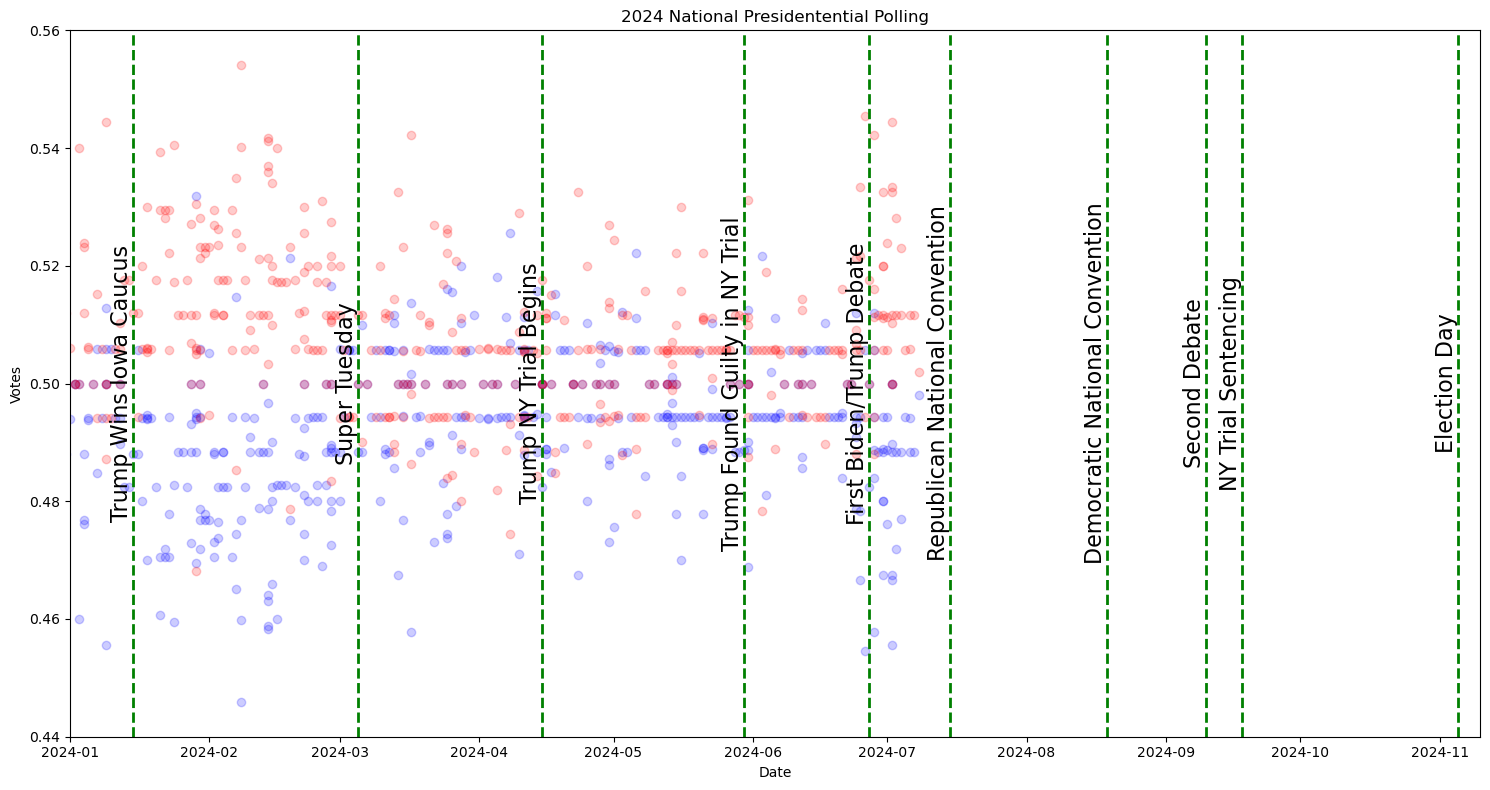

In [200]:
dem_votes = df_2way.query("state == 'US'")["DEM"].values
gop_votes = df_2way.query("state == 'US'")["GOP"].values

dates = df_2way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.44, 0.56)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

# Add large blue dot at the final actual national popular vote for Biden
#ax.plot(dt.datetime(2024, 11, 5), .523, "o", markersize=25, color='blue', alpha=1)

# Add large red dot at the final actual national popular vote for Trump
#ax.plot(dt.datetime(2024, 11, 5), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

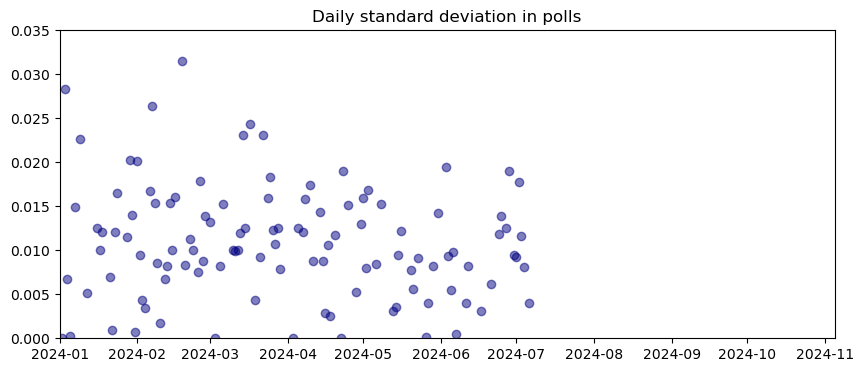

In [201]:
rolling_std = (
    df_2way.query("state == 'US'")[["date", "DEM", "GOP"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'navy',
    alpha=0.5,
)

ax.set_ylim(0, .035)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

Text(0.5, 1.0, 'Daily standard deviation in polls')

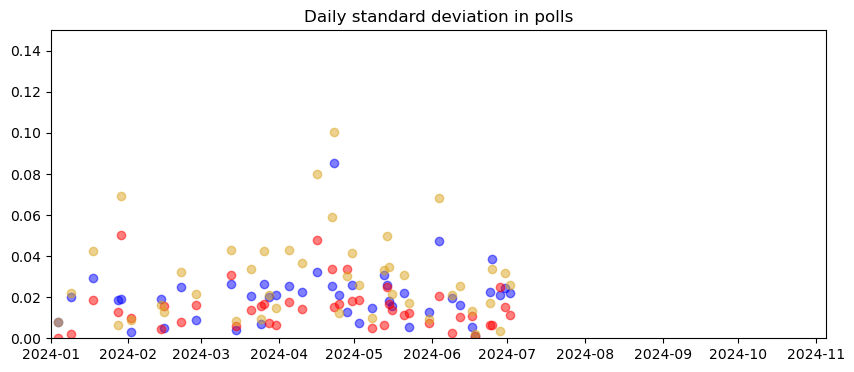

In [202]:
rolling_std = (
    df_3way.query("state == 'US'")[["date", "DEM", "GOP", "IND"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP", "IND"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.IND.values,
    "o",
    color = 'goldenrod',
    alpha=0.5,
)

ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

We can see here that the polling methodology affects responses.

In [203]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'App Panel']")[['methodology','DEM','GOP','IND']].groupby("methodology").mean()

,DEM,GOP,IND
methodology,,,
App Panel,0.452045,0.494119,0.053836
Live Phone,0.458318,0.482095,0.059587
Online Panel,0.475747,0.494752,0.029501
Probability Panel,0.467025,0.477954,0.055022


We can see that Trump fairly consistently out-performs on App Panel polls.

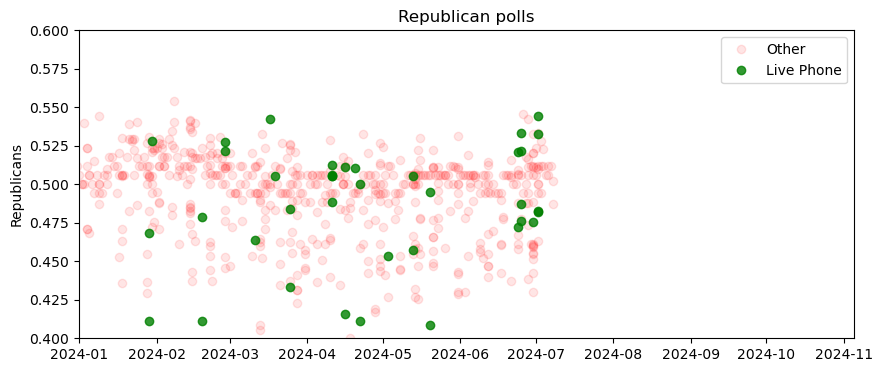

In [204]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "Live Phone"]
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "Live Phone"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="Live Phone")
ax.set_ylim(.4, .6)
ax.set_ylabel("Republicans")
ax.set_title("Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [205]:
df["margin"] = df.apply(lambda row: row['DEM'] - row['IND'] if row['type'] == '2way_bk' else
                        (row['IND'] - row['GOP'] if row['type'] == '2way_tk' else
                         row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "IND", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [206]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]
df["diff_IND"] = df["IND"] - df["IND_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type_tk,margin,GOP_mean,DEM_mean,IND_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_margin
0,2024-07-08,87361,202461,1102,Emerson,IVR/Online Panel/Text-to-Web,US,rv,14.0,2024,...,0,-0.00,0.51,0.49,0.00,-0.03,-0.01,0.01,0.00,0.02
1,2024-07-07,87351,202394,1189,Morning Consult,Online Panel,US,rv,113.0,2024,...,0,-0.02,0.51,0.49,0.00,-0.03,-0.00,0.00,0.00,0.00
2,2024-07-06,87350,202393,1189,Morning Consult,Online Panel,US,rv,40.0,2024,...,0,-0.02,0.51,0.49,0.00,-0.03,-0.00,0.00,0.00,0.00
3,2024-07-06,87358,202426,1329,Bendixen & Amandi International,Live Phone/Online Panel,US,lv,10.0,2024,...,0,-0.01,0.51,0.49,0.00,-0.03,-0.01,0.01,0.00,0.01
4,2024-07-05,87349,202392,1189,Morning Consult,Online Panel,US,rv,40.0,2024,...,0,-0.01,0.51,0.49,0.00,-0.03,-0.01,0.01,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2024-04-21,86826,198196,1705,John Zogby Strategies,Online Panel,WA,lv,4.0,2024,...,1,0.23,0.51,0.00,0.49,-0.01,-0.12,0.00,0.12,0.24
1634,2024-04-21,86827,198199,1705,John Zogby Strategies,Online Panel,WV,lv,4.0,2024,...,1,-0.31,0.51,0.00,0.49,-0.01,0.15,0.00,-0.15,-0.30
1635,2024-04-21,86829,198203,1705,John Zogby Strategies,Online Panel,WI,lv,5.0,2024,...,1,-0.01,0.51,0.00,0.49,-0.01,-0.00,0.00,0.00,0.00
1636,2024-04-21,86830,198206,1705,John Zogby Strategies,Online Panel,WY,lv,2.0,2024,...,1,-0.19,0.51,0.00,0.49,-0.01,0.09,0.00,-0.09,-0.18


Trump has a much greater lead in a three-way race:

In [207]:
100*df.query("state == 'US'").groupby('type')[['margin']].mean()

,margin
type,
2way,-1.614517
2way_bk,-8.163265
2way_tk,0.595948
3way,-3.133399


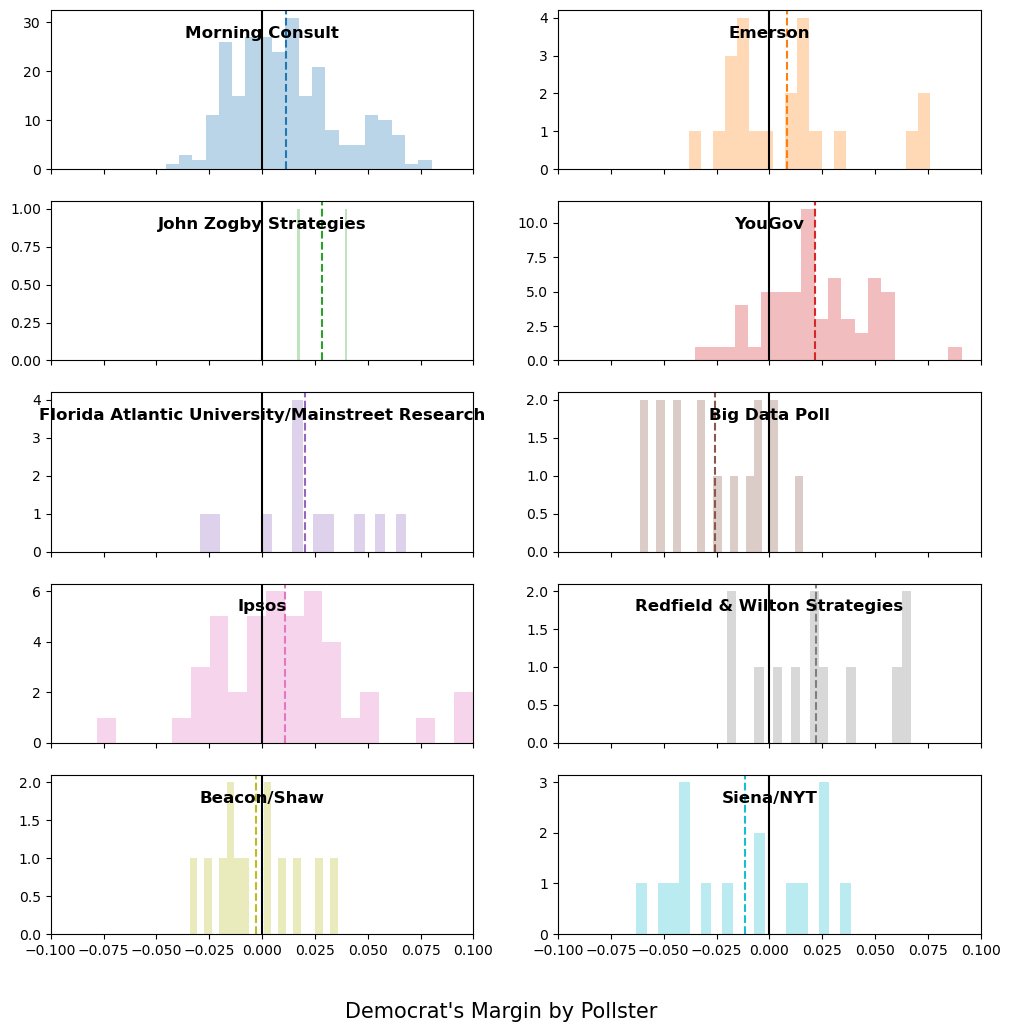

In [208]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.1, .1)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

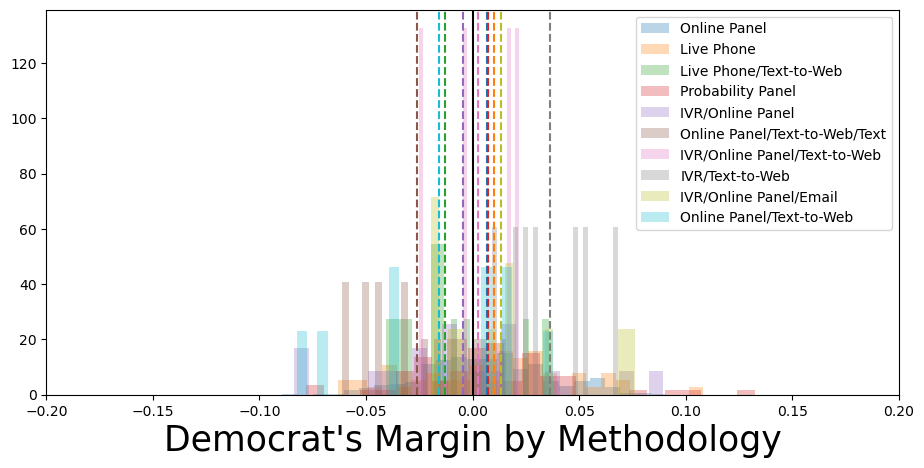

In [209]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [210]:
df = df[~df['type'].isin(['2way_bk', '2way_tk'])]
df = df.dropna()

In [211]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1,2], ['DEM','GOP','IND']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [227]:
with pm.Model(coords=COORDS) as pooled_popularity_simple:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")
    dem_day_effect = pm.GaussianRandomWalk("dem_day_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=-0.025, sigma=0.1), dims="day")
    dem_sigma_3way = pm.HalfNormal("dem_sigma_3way", sigma=0.1) + epsilon   
    dem_3way_walk = pm.GaussianRandomWalk("dem_3way_walk", sigma=dem_sigma_3way, init_dist=pm.Normal.dist(mu=0.148, sigma=0.1), dims="day")

    gop_sigma = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_pop_effect = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")
    gop_day_effect = pm.GaussianRandomWalk("gop_day_effect", sigma=gop_sigma, init_dist=pm.Normal.dist(mu=0.031, sigma=0.1), dims="day")
    gop_sigma_3way = pm.HalfNormal("gop_sigma_3way", sigma=0.1) + epsilon   
    gop_3way_walk = pm.GaussianRandomWalk("gop_3way_walk", sigma=gop_sigma_3way, init_dist=pm.Normal.dist(mu=0.095, sigma=0.1), dims="day")

    ind_sigma = pm.HalfNormal("ind_sigma", sigma=0.1) + epsilon
    ind_pollster_effect = pm.Normal("ind_pollster_effect", 0, 0.2, dims="pollster")
    ind_method_effect = pm.Normal("ind_method_effect", 0, 0.2, dims="method")
    ind_state_effect = pm.Normal("ind_state_effect", 0, 0.2, dims="state")
    ind_pop_effect = pm.Normal("ind_pop_effect", 0, 0.1, dims="population")
    ind_day_effect = pm.GaussianRandomWalk("ind_day_effect", sigma=ind_sigma, init_dist=pm.Normal.dist(mu=-1.567, sigma=0.1), dims="day")

    type_btk = pm.Data("type_btk", df['type_btk'])
    type_bt = pm.Data("type_bt", df['type_bt'])

    dem_polling = (1 - dem_3way_walk[day_id] * type_btk) * pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_state_effect[state_id] +
        dem_pop_effect[population_id] +
        dem_day_effect[day_id]
    )

    gop_polling = (1 - gop_3way_walk[day_id] * type_btk) * pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_state_effect[state_id] +
        gop_pop_effect[population_id] +
        gop_day_effect[day_id]
    )

    ind_polling = (1 - type_bt) * pm.math.invlogit(
        ind_pollster_effect[pollster_id] +
        ind_method_effect[method_id] +
        ind_state_effect[state_id] +
        ind_pop_effect[population_id] +
        ind_day_effect[day_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'],
        dims="observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p=gop_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['GOP'],
        dims="observation",
    )

    ind_vote = pm.Binomial(
        "ind_vote",
        p=ind_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['IND'],
        dims="observation",
    )

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_pop_effect, dem_day_effect, dem_sigma_3way, dem_3way_walk, gop_sigma, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_pop_effect, gop_day_effect, gop_sigma_3way, gop_3way_walk, ind_sigma, ind_pollster_effect, ind_method_effect, ind_state_effect, ind_pop_effect, ind_day_effect]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 367, 367 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 1210 seconds.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [228]:
states = df['state'].unique()
parties = ['dem', 'gop', 'ind', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [241]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean =  pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

for d in tqdm(day):
    for state in states:
        for party in parties[:2]:
            df_results[f"{state}_{party}"] = ((1 - idata.posterior[f"{party}_3way_walk"].sel(day=d)) * inv_logit(
                idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
                idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
                idata.posterior[f"{party}_pop_effect"].sel(population="rv") + #Registered voters
                idata.posterior[f"{party}_day_effect"].sel(day=d)    
            )
              ).values.ravel()
    
        for party in ['ind']:
            df_results[f"{state}_{party}"] = (inv_logit(idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
            idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
            idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
            idata.posterior[f"{party}_pop_effect"].sel(population="rv") + #Registered voters
            idata.posterior[f"{party}_day_effect"].sel(day=d))).values.ravel()
        
        # Extract columns from DataFrame
        df_state = df_results[[f"{state}_dem", f"{state}_gop", f"{state}_ind",]]
        
        # Normalize the columns
        df_state_normalized = df_state.div(df_state.sum(axis=1), axis=0)
        
        # Replace normalized values in original DataFrame
        df_results[[f"{state}_dem", f"{state}_gop", f"{state}_ind"]] = df_state_normalized
    
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_mean.loc[d] = df_results.mean()
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 367/367 [03:02<00:00,  2.01it/s]


In [242]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [243]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_19630/2031796026.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_19630/2031796026.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=

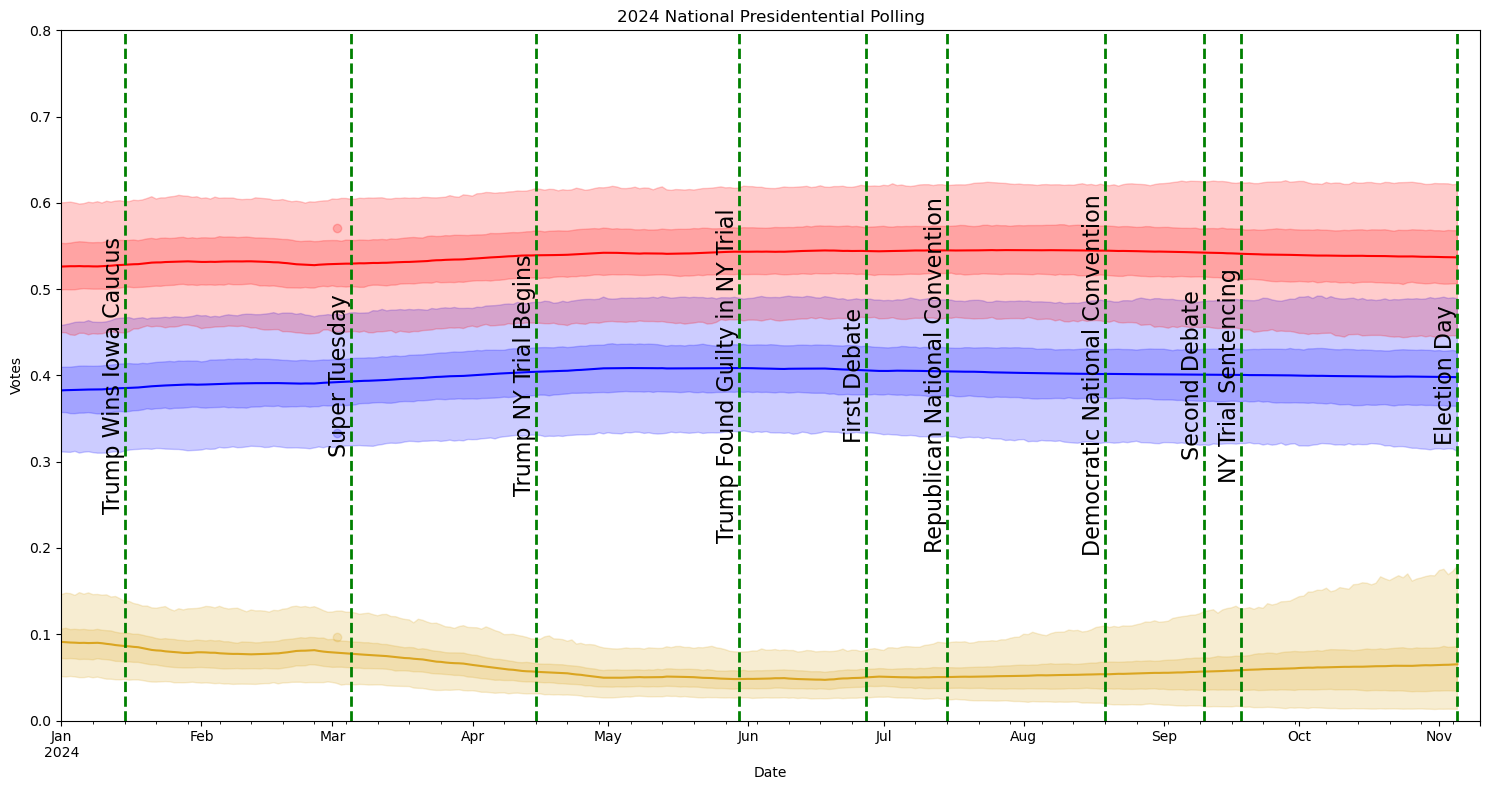

In [254]:
graph_state = 'MT'

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='Republicans 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='Republicans 50% HDI')

df_day_mean[f"{graph_state}_ind"].plot(color='goldenrod', label='Independents Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_ind"].ffill(), df_day_97[f"{graph_state}_ind"].ffill(), color='goldenrod', alpha=0.2, label='Independents 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_ind"].ffill(), df_day_75[f"{graph_state}_ind"].ffill(), color='goldenrod', alpha=0.2, label='Independents 50% HDI')

dem_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["GOP"]
ind_votes = df_3way.set_index('date').query(f"state == '{graph_state}'")["IND"]

ax.plot(dem_votes.index, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(gop_votes.index, gop_votes, "o", alpha=0.2, color='red', label="Trump")
ax.plot(ind_votes.index, ind_votes, "o", alpha=0.2, color='goldenrod', label="Kennedy")

# Set limits and labels
ax.set_ylim(0, .8)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.4, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_19630/285197138.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_19630/285197138.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.

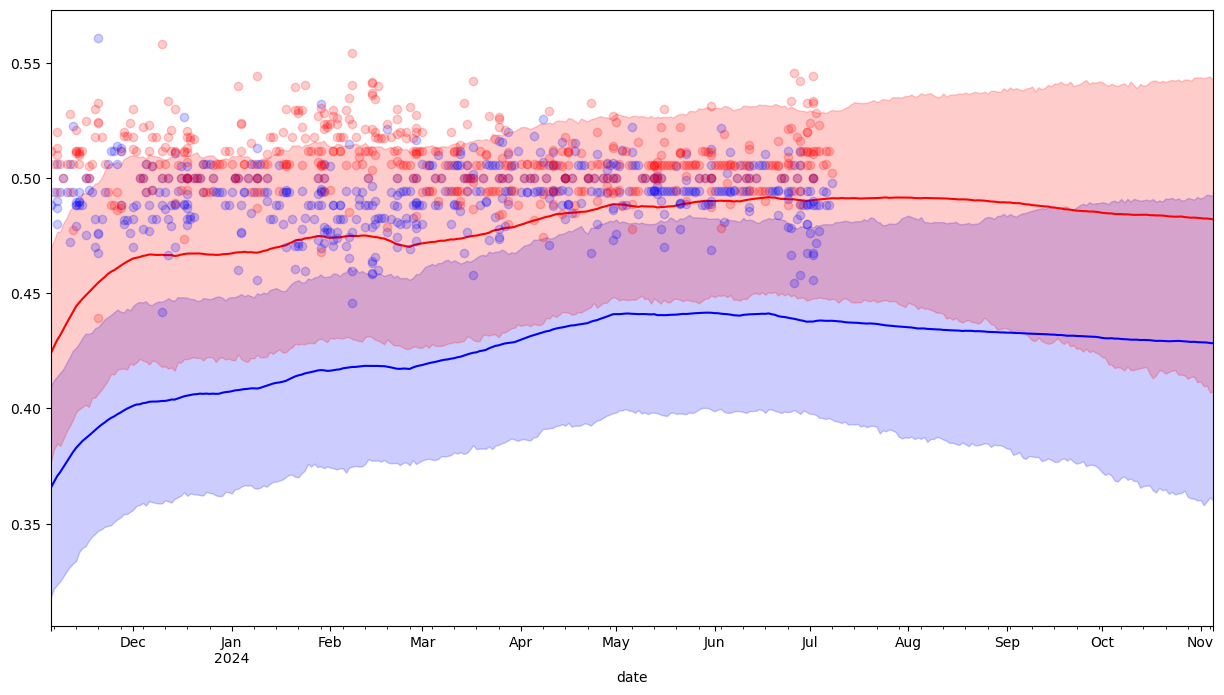

In [236]:
fig, ax = plt.subplots(figsize=(15, 8))

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Democrats 94% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='Republicans 94% HDI')

ax.plot(dem_votes.index, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(gop_votes.index, gop_votes, "o", alpha=0.2, color='red', label="Trump")

plt.show()

In [239]:
df_results

,US_dem,US_gop,US_ind,US_margin,AZ_dem,AZ_gop,AZ_ind,AZ_margin,MI_dem,MI_gop,...,SC_ind,SC_margin,SD_dem,SD_gop,SD_ind,SD_margin,NE-2_dem,NE-2_gop,NE-2_ind,NE-2_margin
0,0.438766,0.483057,0.078177,-0.044291,0.446500,0.514806,0.038695,-0.068306,0.424720,0.523172,...,0.059479,-0.221383,0.462631,0.484040,0.053328,-0.021409,0.399123,0.546644,0.054233,-0.147522
1,0.385085,0.512137,0.102778,-0.127053,0.366145,0.563518,0.070338,-0.197373,0.412245,0.517186,...,0.059998,-0.178697,0.325321,0.598691,0.075988,-0.273370,0.393896,0.520180,0.085924,-0.126285
2,0.424775,0.509476,0.065749,-0.084702,0.431798,0.534478,0.033724,-0.102680,0.401989,0.562460,...,0.048826,-0.242819,0.394735,0.567087,0.038177,-0.172352,0.430061,0.536823,0.033116,-0.106762
3,0.366671,0.527007,0.106322,-0.160336,0.348947,0.575594,0.075458,-0.226647,0.389890,0.522050,...,0.079178,-0.191755,0.321890,0.597176,0.080934,-0.275286,0.288909,0.612173,0.098918,-0.323264
4,0.407629,0.485403,0.106968,-0.077773,0.410912,0.525219,0.063869,-0.114307,0.408404,0.539685,...,0.072956,-0.132665,0.409286,0.517292,0.073422,-0.108005,0.464694,0.471399,0.063907,-0.006706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.371117,0.430756,0.198127,-0.059639,0.361359,0.510044,0.128597,-0.148685,0.369249,0.459945,...,0.147496,-0.119920,0.320407,0.510142,0.169451,-0.189735,0.357885,0.505771,0.136344,-0.147886
996,0.431401,0.474409,0.094190,-0.043008,0.404345,0.528099,0.067556,-0.123753,0.412163,0.533103,...,0.069625,-0.056958,0.385312,0.554690,0.059998,-0.169379,0.431464,0.515953,0.052583,-0.084489
997,0.366559,0.484004,0.149437,-0.117445,0.349082,0.544709,0.106209,-0.195627,0.406064,0.492932,...,0.108512,-0.270034,0.314718,0.550043,0.135239,-0.235326,0.398872,0.463198,0.137930,-0.064325
998,0.398694,0.540262,0.061044,-0.141568,0.390140,0.570831,0.039030,-0.180691,0.370749,0.587374,...,0.044347,-0.128479,0.410462,0.552564,0.036974,-0.142102,0.362720,0.602176,0.035104,-0.239455


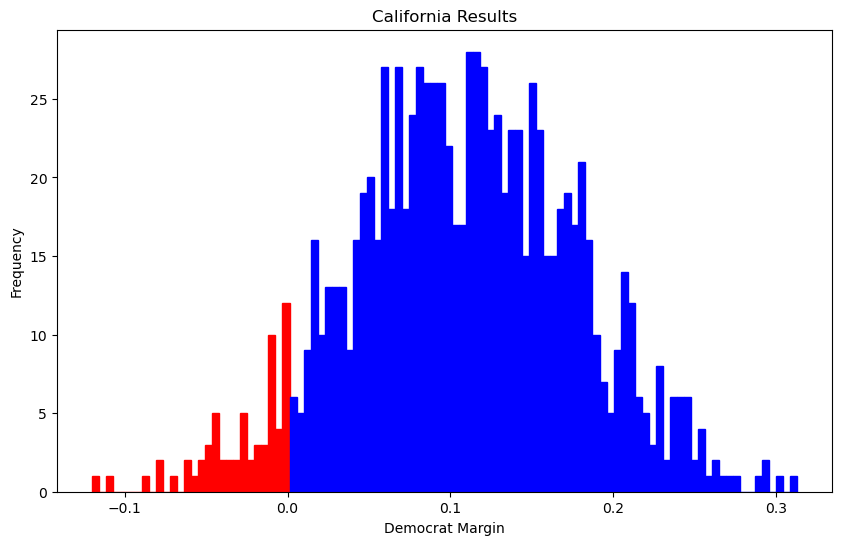

In [237]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

ax = df_results['CA_margin'].plot.hist(bins = 100)

for bar in ax.containers[0]:
    # get x midpoint of bar
    x = bar.get_x() + 0.5 * bar.get_width()

    # set bar color based on x
    if x < 0:
        bar.set_color('red')
    elif x > 0:
        bar.set_color('blue')
    else:
        bar.set_color('green')

# Adding titles and labels
plt.title('California Results')
plt.xlabel('Democrat Margin')
plt.ylabel('Frequency')

# Display the plot
plt.show()


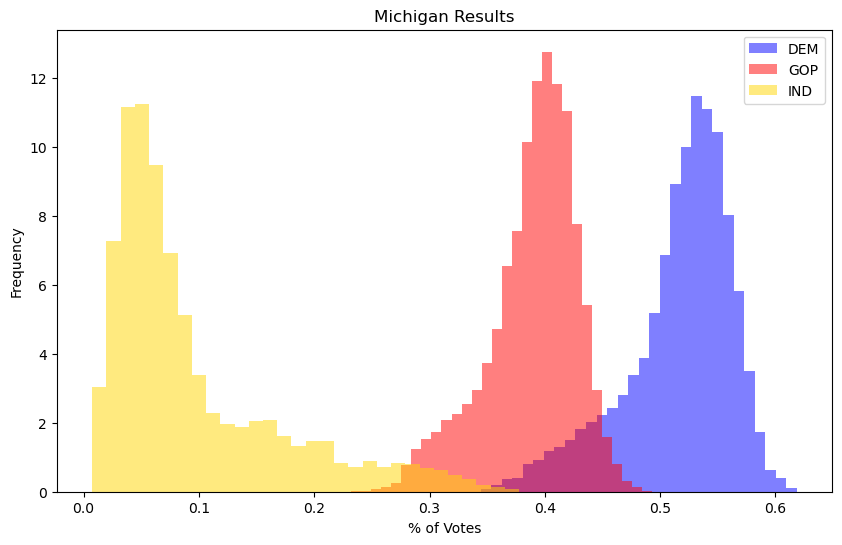

In [56]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

plt.hist(df_results['CA_dem'], bins=30, alpha=0.5, color='blue', label='DEM', density=True)
plt.hist(df_results['CA_gop'], bins=30, alpha=0.5, color='red', label='GOP', density=True)
plt.hist(df_results['CA_ind'], bins=30, alpha=0.5, color='goldenrod', label='IND', density=True)

# Adding titles and labels
plt.title('Michigan Results')
plt.xlabel('% of Votes')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Display the plot
plt.show()


In [117]:
df_results

,AZ_dem,AZ_gop,AZ_oth,AZ_ind,AZ_margin,MI_dem,MI_gop,MI_oth,MI_ind,MI_margin,...,NE-2_dem,NE-2_gop,NE-2_oth,NE-2_ind,NE-2_margin,DE_dem,DE_gop,DE_oth,DE_ind,DE_margin
0,0.283422,0.216317,0.261376,0.238886,0.067105,0.297945,0.212021,0.263864,0.226170,0.085924,...,0.294921,0.207681,0.276149,0.221249,0.087241,0.280488,0.192902,0.302893,0.223718,0.087586
1,0.295924,0.213904,0.206103,0.284069,0.082020,0.309059,0.213863,0.207106,0.269971,0.095196,...,0.296139,0.192676,0.231943,0.279242,0.103463,0.310866,0.193770,0.250154,0.245211,0.117096
2,0.308712,0.217013,0.226409,0.247867,0.091699,0.325610,0.212153,0.230972,0.231265,0.113456,...,0.325930,0.189713,0.243588,0.240769,0.136217,0.316361,0.201255,0.261990,0.220393,0.115106
3,0.291440,0.222079,0.238006,0.248475,0.069361,0.305059,0.220051,0.236601,0.238289,0.085008,...,0.278802,0.211992,0.256846,0.252360,0.066810,0.298323,0.187482,0.283421,0.230775,0.110841
4,0.309938,0.229338,0.209367,0.251357,0.080600,0.324853,0.224396,0.214739,0.236012,0.100456,...,0.312658,0.219945,0.235335,0.232063,0.092713,0.305845,0.225252,0.261126,0.207777,0.080593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.299835,0.335282,0.073141,0.291742,-0.035446,0.324045,0.333974,0.075232,0.266750,-0.009929,...,0.302197,0.320374,0.083579,0.293851,-0.018177,0.314201,0.338184,0.091729,0.255886,-0.023983
996,0.300150,0.353348,0.067412,0.279090,-0.053197,0.316765,0.352866,0.066602,0.263767,-0.036101,...,0.301463,0.343159,0.078120,0.277259,-0.041696,0.313540,0.333560,0.085087,0.267813,-0.020020
997,0.281830,0.340895,0.081644,0.295631,-0.059066,0.300256,0.342075,0.082493,0.275176,-0.041818,...,0.301911,0.320303,0.088667,0.289119,-0.018393,0.299271,0.330063,0.108105,0.262562,-0.030791
998,0.302771,0.360602,0.057563,0.279065,-0.057831,0.320890,0.357694,0.058472,0.262944,-0.036804,...,0.301802,0.345224,0.070938,0.282036,-0.043422,0.324542,0.327928,0.080938,0.266593,-0.003386


In [118]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    ind_votes = df_results[f"{state}_ind"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > max(gop_votes[i], ind_votes[i])
         else "gop" if gop_votes[i] > max(dem_votes[i], ind_votes[i])
         else "ind" if ind_votes[i] > max(dem_votes[i], gop_votes[i])
         else "tie"
         for i in range(len(df_results))]
    )

In [119]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_ind = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]
    df_ind[state] = df_results[f"{state}_ind"]
    df_oth[state] = df_results[f"{state}_oth"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['ind'] = df_ind.mean()
df_mean['oth'] = df_oth.mean()
df_mean['margin'] = df_margin.mean()

In [120]:
df_mean.sort_values('margin')

,dem,gop,oth,ind,margin
WY,0.206459,0.385081,0.166676,0.241784,-0.178622
OK,0.221245,0.383373,0.173709,0.221673,-0.162128
WV,0.224916,0.372817,0.191653,0.210614,-0.147901
SD,0.225857,0.358204,0.190210,0.225730,-0.132347
KY,0.232282,0.363287,0.170889,0.233541,-0.131005
ID,0.230684,0.356975,0.186358,0.225983,-0.126290
TN,0.227271,0.353044,0.194388,0.225297,-0.125773
AL,0.249239,0.375003,0.160815,0.214943,-0.125765
UT,0.205460,0.319582,0.222447,0.252511,-0.114122
AR,0.242238,0.355653,0.173218,0.228891,-0.113415


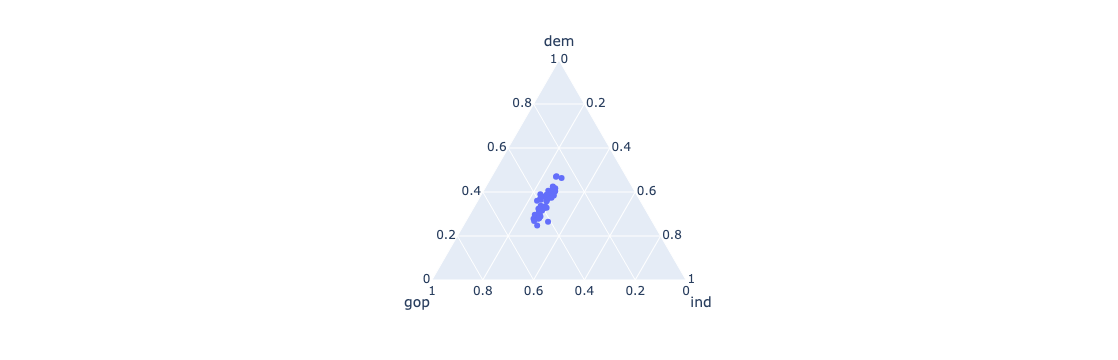

In [121]:
import plotly.express as px
df = px.data.election()
fig = px.scatter_ternary(df_mean, a="dem", b="gop", c="ind", #hover_name="candidate",
    #color="winner", size="total", size_max=15,
    #color_discrete_map = {"dem": "blue", "gop": "red", "ind":"gold"}
                        )
fig.show()


In [304]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_state_effect'].mean(axis=0).mean(axis=0).values
df_post['state'] = idata.posterior['dem_state_effect'].state.values

df_post.groupby('state').mean()

,mean_dem,mean_gop,mean_ind,mean_oth
state,,,,
AK,-0.014094,0.010921,0.007801,-0.205902
AL,-0.013673,0.025787,0.022494,-0.252286
AR,-0.017523,-0.001986,-0.003221,-0.164394
AZ,-0.015324,0.019663,0.013714,-0.226702
CA,-0.014578,-0.072620,-0.049309,-0.010664
CO,-0.021643,-0.049962,-0.036258,-0.050991
CT,-0.020218,-0.037848,-0.028683,-0.076966
DE,0.021604,-0.033773,-0.111426,0.041228
FL,-0.020171,0.027139,0.013836,-0.229655


<Axes: xlabel='president'>

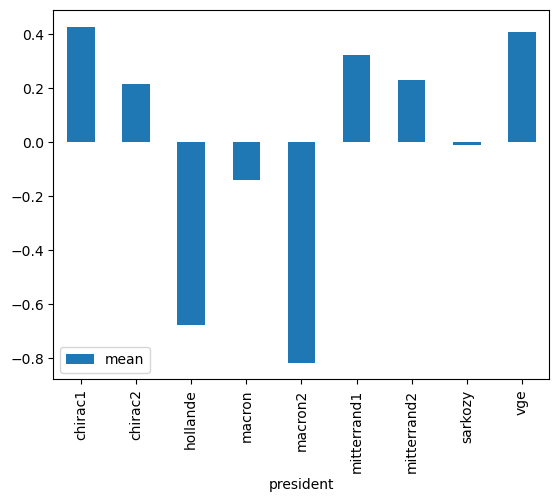

In [19]:
df = pd.DataFrame()

df = pd.DataFrame()
df['mean'] = idata.posterior['president_effect'].mean(axis=0).mean(axis=0).values
df['president'] = idata.posterior['president_effect'].president.values

df.groupby('president').mean().plot(kind="bar")

<Axes: xlabel='week'>

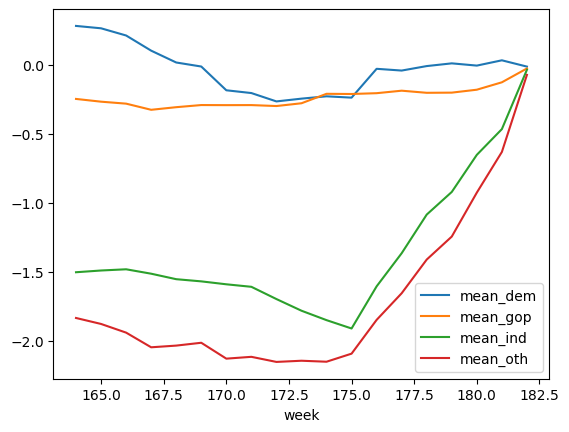

In [1207]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_week_effect'].mean(axis=0).mean(axis=0).values
df_post['week'] = idata.posterior.week.values

df_post.groupby('week').mean().plot()

In [960]:
def plot_latent_mu(inference_data, overlay_observed=True):
    """Plot latent posterior popularity"""
    post_pop = logistic(
        inference_data.posterior["dem_week_effect"].stack(sample=("chain", "draw"))
    )

    fig, ax = plt.subplots()

    # plot random posterior draws
    ax.plot(
        inference_data.posterior.coords["week"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )

    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")

    ax.set_xlabel("Months into term")
    ax.set_ylabel("Does approve")
    ax.legend()

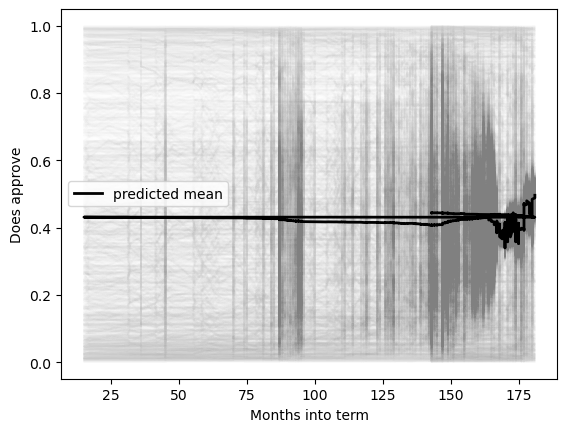

In [961]:
plot_latent_mu(idata)

In [23]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
-   ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

COORDS["month_minus_origin"] = COORDS["month"][1:]

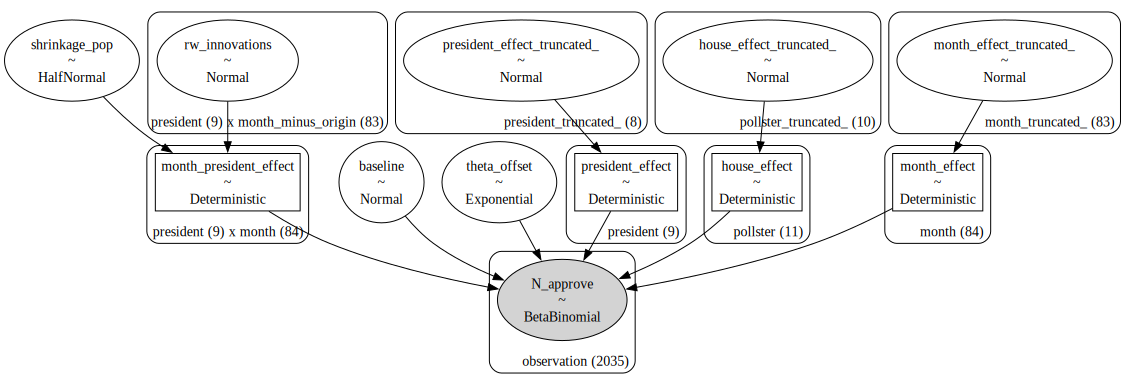

In [24]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [25]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, president_effect_truncated_, house_effect_truncated_, month_effect_truncated_, rw_innovations, shrinkage_pop, theta_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 267 seconds.


/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


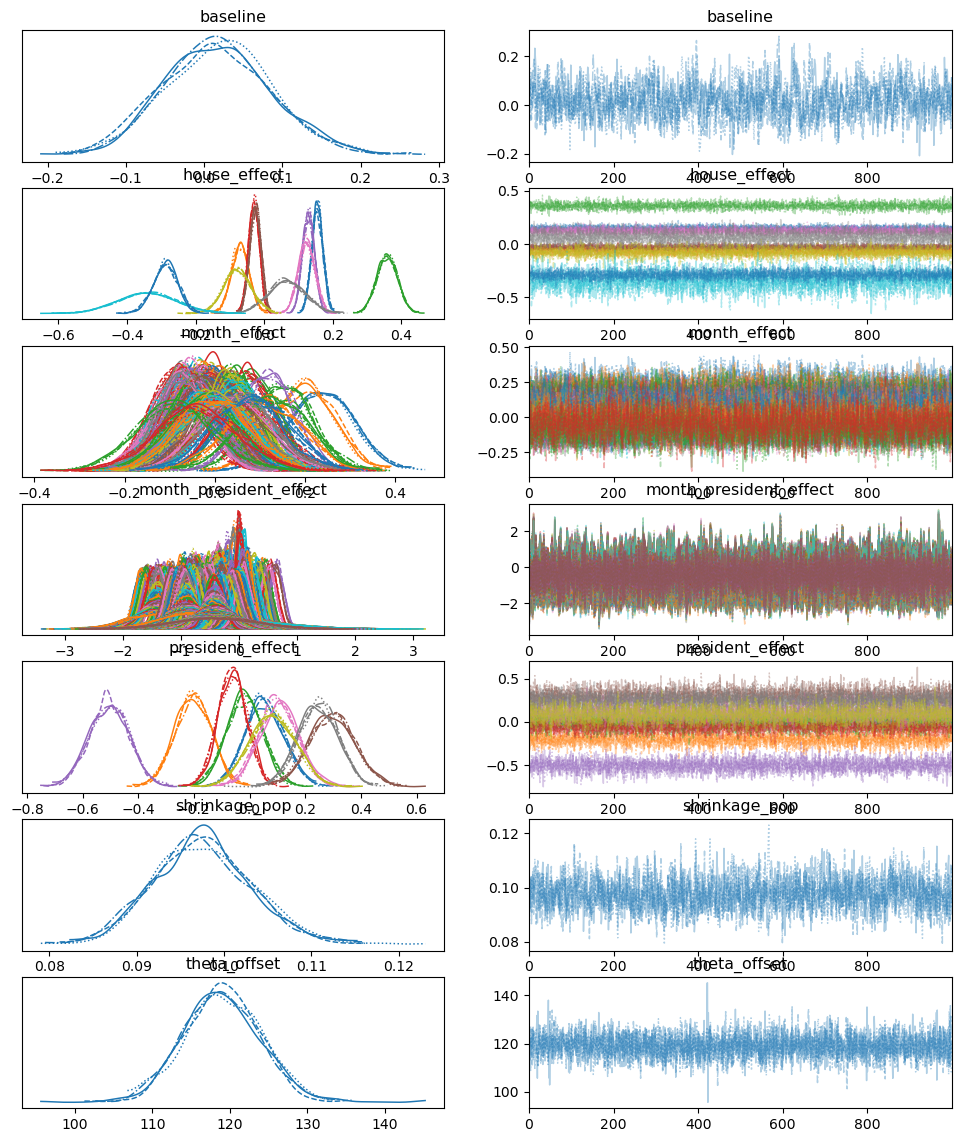

In [26]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [27]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,0.02,0.07,-0.11,0.15,0.00,0.00,894.76,1653.80,1.0
house_effect[BVA],0.16,0.02,0.13,0.19,0.00,0.00,2700.10,2782.97,1.0
house_effect[Elabe],-0.07,0.03,-0.12,-0.02,0.00,0.00,4202.10,3294.66,1.0
house_effect[Harris],0.36,0.03,0.30,0.41,0.00,0.00,4574.67,3096.85,1.0
house_effect[Ifop],-0.03,0.02,-0.06,-0.00,0.00,0.00,2039.60,2604.14,1.0
...,...,...,...,...,...,...,...,...,...
president_effect[mitterrand2],0.10,0.07,-0.03,0.23,0.00,0.00,3553.36,2782.25,1.0
president_effect[sarkozy],0.25,0.07,0.12,0.38,0.00,0.00,3302.49,2867.73,1.0
president_effect[vge],0.08,0.08,-0.07,0.23,0.00,0.00,3841.99,3203.38,1.0
shrinkage_pop,0.10,0.01,0.09,0.11,0.00,0.00,1359.82,2468.22,1.0


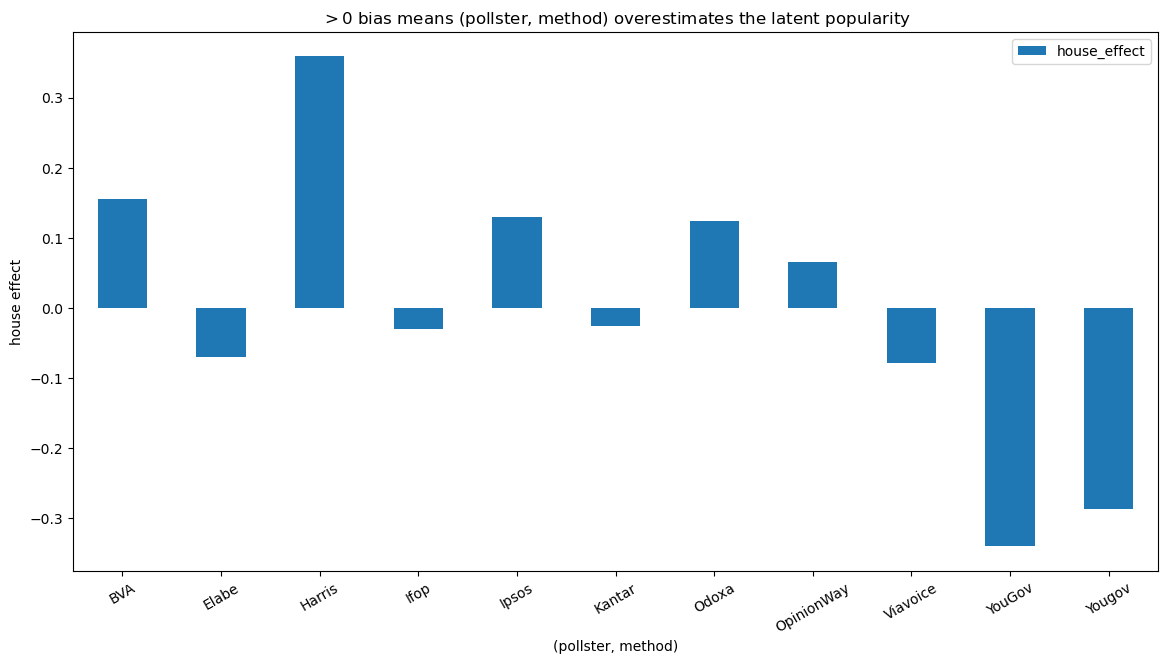

In [28]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");


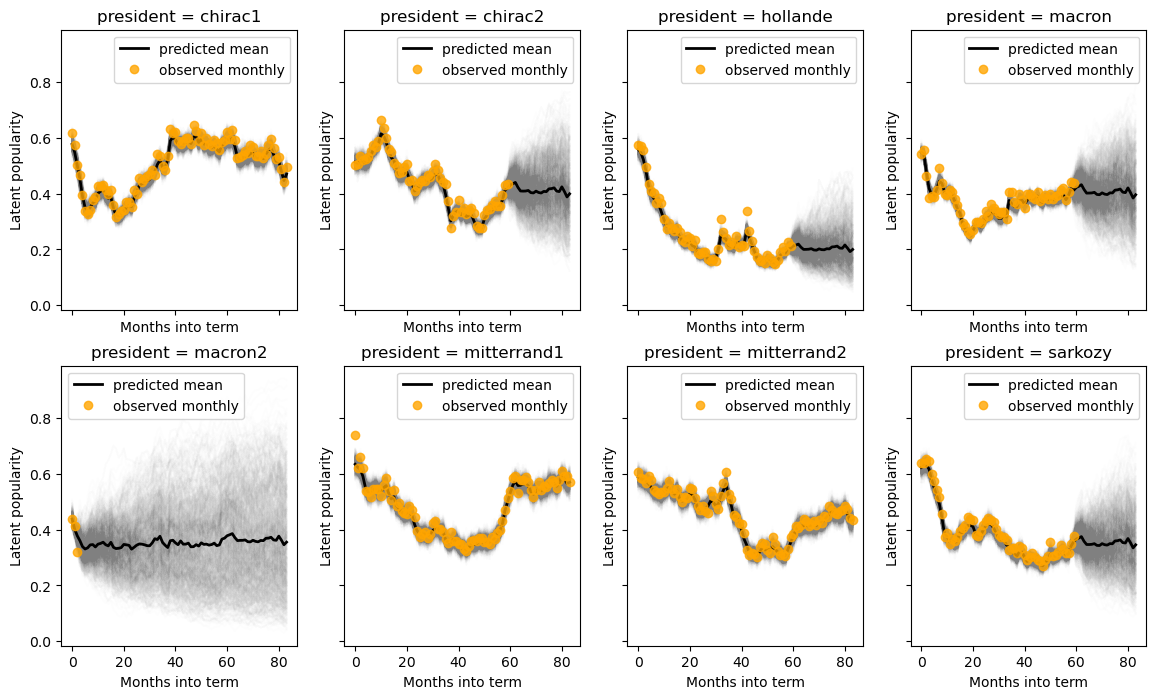

In [29]:
obs_mean = (data.groupby(["president", "month_id"]).last()["approve_pr_mean"]/100).unstack().T

fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()